In [58]:
import os
import re
import pandas as pd
from graphviz import Source

In [59]:
pwd = '/home/gautam/robotmx/MXSampleMounting/'

files = [f for f in os.listdir(pwd) if re.match(r'[A-z]*.prg', f)]
files = [f  for f in files if '.bak' not in f]

In [60]:
file_names = []
function_names = []
function_startlinenums = []
function_endlinenums = []

for fileName in files:
    #fileName = files[0]
    fhandle = open(pwd+fileName,'r')
    readlines = fhandle.readlines()

    temp_func_startlinenums = []
    temp_func_endlinenums = []
    for start_line_num in range(len(readlines)):
        if re.match(r'^Function ',readlines[start_line_num].strip()):
            temp_func_startlinenums.append(start_line_num)
            for end_line_num in range(start_line_num,len(readlines)):
                if 'Fend' in readlines[end_line_num]:                    
                    temp_func_endlinenums.append(end_line_num)
                    break

    function_startlinenums = function_startlinenums + temp_func_startlinenums
    function_endlinenums = function_endlinenums + temp_func_endlinenums

    for line_num in temp_func_startlinenums:
        function_names.append(re.split(" |\(|\n",readlines[line_num])[1])
        file_names.append(fileName)

    fhandle.close()

In [61]:
df = pd.DataFrame({"filename":file_names, 
                   "Function":function_names, 
                   "startlineNumber":function_startlinenums,
                   "endlineNumber":function_endlinenums
                  })

df = df[["filename","startlineNumber","endlineNumber","Function"]]
df[df.filename == "pythoninterface.prg"]

,filename,startlineNumber,endlineNumber,Function
98,pythoninterface.prg,9,25,GTParseCassettePosition
99,pythoninterface.prg,27,70,GTParsePortIndex
100,pythoninterface.prg,73,85,PrepareForMountDismount
101,pythoninterface.prg,87,162,ProbeCassettes
102,pythoninterface.prg,164,220,JSONDataRequest
103,pythoninterface.prg,221,224,MountSamplePortAndGoHome
104,pythoninterface.prg,225,321,MountSamplePort
105,pythoninterface.prg,322,329,DismountSampleAndGoHome
106,pythoninterface.prg,330,373,DismountSample
107,pythoninterface.prg,376,446,FindPortCenters


In [62]:
fileName = "pythoninterface.prg"
fhandle = open(pwd+fileName,'r')
readlines = fhandle.readlines()
print(readlines[25])
fhandle.close()

Fend



In [63]:
#from IPython.display import display
#display(df[df.filename == "pythoninterface.prg"])
#for fileName in files:
#    display(df[df.filename == fileName])

In [64]:
function_list = df['Function'].tolist()
funcRegex = '('+'|'.join(function_list)+')'
funcRegexCompilation = re.compile(funcRegex)
exclusionRegex = '(msg|g_RunResult|UpdateClient|Print|\')'#|True$|False$)'
exclusionRegexCompilation = re.compile(exclusionRegex)

In [65]:
funcsList_inside_func = []
for fileName in files:
    #fileName = "pythoninterface.prg"

    df_of_funcs_in_this_file = df[df.filename == fileName]
    #df_of_funcs_in_this_file.sort_values(by='startlineNumber',ascending=True)
    funcs_in_this_file = df_of_funcs_in_this_file['Function'].tolist()
    #df_of_funcs_in_this_file.reindex(range(len(funcs_in_this_file)))
    #display(df_of_funcs_in_this_file)

    fhandle = open(pwd+fileName,'r')
    readlines = fhandle.readlines()
    fhandle.close()

    #funcsList_inside_func = []
    for funcIndex in df_of_funcs_in_this_file.index:
        functionName = df_of_funcs_in_this_file.loc[funcIndex,'Function']
        startLineNum = df_of_funcs_in_this_file.loc[funcIndex,'startlineNumber']
        endLineNum = df_of_funcs_in_this_file.loc[funcIndex,'endlineNumber']
        funcs_inside_func = []
        for lineNum in range(startLineNum+1,endLineNum):
            line = readlines[lineNum].strip()
            if not (exclusionRegexCompilation.match(line) or re.search("[^A-Z]"+functionName,line)):
                searchedObject = funcRegexCompilation.search(line)
                if searchedObject:
                    funcs_inside_func.append(searchedObject.group())
        funcsList_inside_func.append(funcs_inside_func)

    #print(len(funcsList_inside_func))

In [66]:
df['funcsInside'] = funcsList_inside_func
#df

In [67]:
funcsdf = df[['Function','funcsInside']]
#funcsdf

In [68]:
def dotStringListGenerator(interestedFunction, insideFuncsList):    
    dotStringList =[]
    for funct in insideFuncsList:
        dotStringList.append(interestedFunction+" -> "+funct)
    return dotStringList

def generateChildList(parentList):
    ChildFuncsList = []
    dotChildList = []
    for parentFunction in parentList:
        tempChildFuncsList = funcsdf[funcsdf.Function == parentFunction]['funcsInside'].tolist()[0]
        ChildFuncsList = ChildFuncsList + tempChildFuncsList
        dotChildList = dotChildList + dotStringListGenerator(parentFunction,tempChildFuncsList)
    #Making calls unique, we loose order of sequence
    ChildFuncsSet = set(ChildFuncsList)
    ChildFuncsList = list(ChildFuncsSet)
   
    return ChildFuncsList,dotChildList

In [69]:
interestedFunction = ["MountSamplePort"]
graphList = []

FuncsNextGenList, dotNextGenList = generateChildList(interestedFunction)
graphList = graphList + dotNextGenList

numGenerations = 5
for i in range(2,numGenerations):
    FuncsNextGenList, dotNextGenList = generateChildList(FuncsNextGenList)
    graphList = graphList + dotNextGenList

#Making calls unique, we loose order of sequence
graphSet = set(graphList)
graphList = list(graphSet)

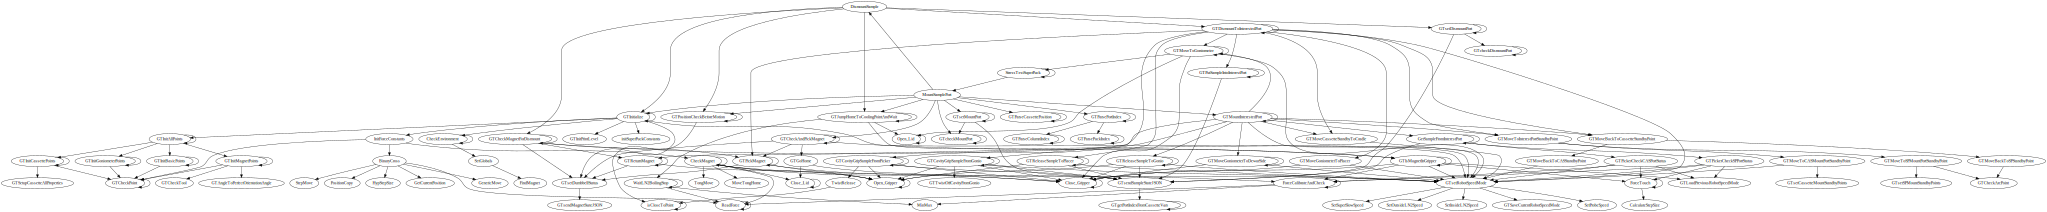

In [70]:
src = Source("digraph {\n"+'\n'.join(graphList)+"\n}\n")
src

In [71]:
def dotStringFunctionSequenceListGenerator(interestedFunction, insideFuncsList):    
    dotStringList =[]
    prevFunction = interestedFunction
    for funct in insideFuncsList:
        dotStringList.append(prevFunction+" -> "+funct)
        prevFunction = funct
    return dotStringList

def generateChildSequenceList(parentList):
    ChildFuncsList = []
    dotChildList = []
    for parentFunction in parentList:
        tempChildFuncsList = funcsdf[funcsdf.Function == parentFunction]['funcsInside'].tolist()[0]
        ChildFuncsList = ChildFuncsList + tempChildFuncsList
        dotChildList = dotChildList + dotStringFunctionSequenceListGenerator(parentFunction,tempChildFuncsList)
    return ChildFuncsList,dotChildList

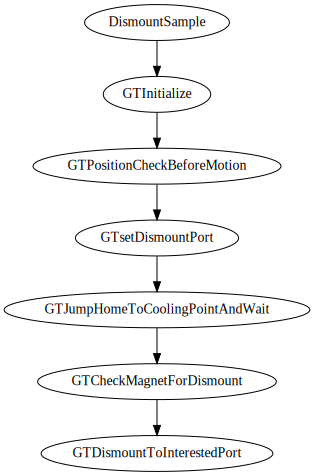

In [72]:
interestedFunction = ["DismountSample"]
graphList = []

Funcs1stGenList, dot1stGenList = generateChildSequenceList(interestedFunction)
graphList = graphList + dot1stGenList

src = Source("digraph {"+' '.join(graphList)+"}")
src

In [82]:
#This prints all the callers Functions which call the interestedFunction
interestedFunction = ["GTReturnMagnet"]
callerFunctions = [parentFunction for parentFunction in funcsdf["Function"] \
if interestedFunction[0] in funcsdf[funcsdf.Function == parentFunction]['funcsInside'].tolist()[0]]
callerFunctions

['GTMountInterestedPort',
 'TransportSamplePickerToPlacer',
 'ProbeCassettes',
 'DismountSampleAndGoHome',
 'FindPortCenters',
 'GTCheckMagnetForDismount',
 'GTReturnMagnet',
 'GTReturnMagnetAndGoHome']